In [1]:
import math
import random
import os

import numpy as np

from comet_ml import API
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

COMET_API_KEY="bSyRm6vJpAwfehizXic7Fo0bY"
COMET_REST_API_KEY="S3g50KZWG8zEgk1PLzKUn0eEq"


error_metric = 'standard_error' # can also be std

In [34]:
def read_conf_matrix(cm, pos_class):                                                                
    """ Calculates confusion matrix and returns true and false positives and negatives based on the 
    label specified as positive.                                                                    
                                                                                                    
    This function assumes that the classes have IDs 0, 1, 2,...                                     
                                                                                                    
    Args:                                                                                           
        y_true: True labels. 1d array or list                                                       
        y_pred: Predicted labels. 1d array or list                                                  
        classes: List of IDs of class labels. dim=n_classes                                         
        pos_class: ID of label to take as positive class                                            
                                                                                                    
    Returns:                                                                                        
        cm: confusion matrix of n_labels x n_labels                                                 
        tp: true positives                                                                          
        tn: true negatives                                                                          
        fp: false positives                                                                         
        fn: false negatives                                                                         
    """                                                                                             
    cm = np.array(cm)
    n_classes = 2
    tp = tn = fp = fn = p = n = 0
    pos_class = 1
    for row in range(n_classes):                                                                    
        for col in range(n_classes):                                                                
            if row == col:                                                                          
                if row == pos_class:                                                                
                    tp = cm[row,col]                                                                
                else:                                                                               
                    tn += cm[row,col]                                                               
            else:                                                                                   
                if col == pos_class:                                                                
                    fp += cm[row,col]                                                               
                else:                                                                               
                    fn += cm[row,col]                                                               
            if row == pos_class:        # TODO: it might be possible to optimise this and not have another if statement.
                p += cm[row, col]                                                                   
                                                                                                    
    return tp, tn, fp, fn, p, n     # TODO: function doesn't yet calculate 'n'                      

def parse_conf_mat(exp_id):
    exp = client.get_experiment_stdout(exp_id)
    confusion_mat = exp.split('Evaluate')[1].split('Confusion matrix: \n ')[1].split('Testing accuracy')[0]

    matrix = []
    for part in confusion_mat.split('\n')[2:]:
        a = part.split('[  0.   0. ')[1].replace(']','')
        a = np.array(a.split(' '))
        x = np.nonzero(a)
        matrix.append([float(str(y)) for y in a[x]])
    # make sure the numbers add up:
    assert int(np.sum(matrix)) == 312

    tp, fp = matrix[0][0], matrix[0][1]
    fn, tn = matrix[1][0], matrix[1][1]
    return matrix

def specificity(tp, tn, fp, fn, p, n):
    return tn / (tn + fp)

def recall(tp, tn, fp, fn, p, n):
    return sensitivity(tp, fp, fn, tn, p, n)
    
def sensitivity(tp,tn,fp,fn, p, n):
    return tp / p

def precision(tp,tn,fp,fn, p, n):
    return tp / (tp + fp)

def f1(*args):
    pr = precision(*args)
    rc = sensitivity(*args)
    val =  (2 * pr * rc ) / ( pr + rc)
    return val


In [35]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto")

results = {
    'no-transfer': [],
    'human-sc': [],
    'human-sitw': [],
    'human-vctk': [],
    'nohuman-esc50': [],
    'nohuman-audioset': [], 
    #'svm': [],   
}

result_matrices = {
    'no-transfer': [],
    'human-sc': [],
    'human-sitw': [],
    'human-vctk': [],
    'nohuman-esc50': [],
    'nohuman-audioset': [], 
    #'svm': [],   
}


for exp in experiments:
    tags = client.get_experiment_tags(exp)
    
    if len(tags) > 0 and tags[0] in results.keys():
        tag = tags[0]
        metrics = client.get_experiment_metrics(exp)
        params = client.get_experiment_parameters(exp)
        for metric in metrics:
            if metric['name'] == 'test_F1':
                results[tag].append(metric['valueMax'])
        mat = read_conf_matrix(parse_conf_mat(exp), 1)
        result_matrices[tag].append(mat)

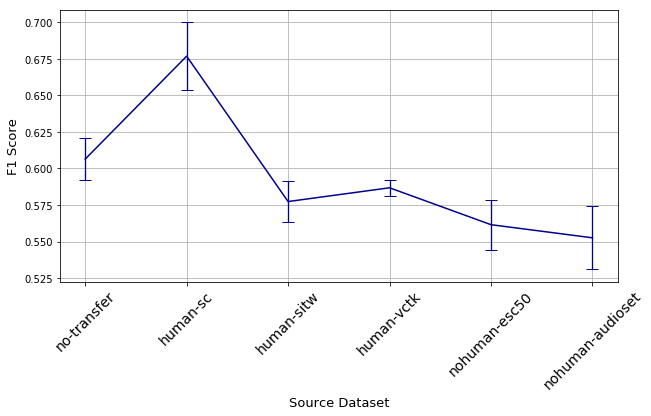

In [36]:
errors = []
xs = []
ys = []
for idx, (k, values) in enumerate(results.items()):
    xs.append(k)
    values = [float(v) for v in values]
    ys.append(np.mean(values))
    if error_metric == 'standard_error':
        errors.append(stats.sem(values))
    else:
        errors.append(np.std(values))

fig, ax = plt.subplots(figsize=(10,5))

el = ax.errorbar(xs, ys, yerr=errors, fmt='-', color='darkblue', ecolor='darkblue', elinewidth=1.3, capsize=6)
elines = el.get_children()
#elines[3].set_color('green')
ax.set_xticklabels(results.keys(), rotation=45, fontsize=14)
ax.set_ylabel('F1 Score', fontsize=13)
ax.set_xlabel('Source Dataset', fontsize=13)
plt.grid()
plt.show()




In [37]:
rows = []
for key in result_matrices.keys():
    for mat in result_matrices[key]:
        ss = sensitivity(*mat)
        sp = specificity(*mat)
        pr = precision(*mat)
        f = f1(*mat)
        rows.append((key, ss, sp, pr, f))
import pandas as pd


def pct(val):
    if type(val) == str:
        return val
    v = round(val * 100, 2)
    return v

def mean(val):
    x = np.mean(val)
    return f'{round(x,1)}'

def std(val):
    x = np.std(val)
    return round(x,1)

def serr(val):
    x = stats.sem(val)
    return round(x,1)


df = pd.DataFrame(rows, columns=["Model", "Sensitivity (%)", "Specificity (%)", "Precision (%)", "F1"])
df = df.applymap(pct)
if error_metric == 'standard_error':
    table = df.groupby("Model")["Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, serr])
else:
    table = df.groupby("Model")["Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, std])
display(table)
print(table.to_latex())

Sensitivity (%)      Specificity (%)      Precision (%)       \
                            mean serr            mean serr          mean serr   
Model                                                                           
human-sc                    78.1  5.4            89.4  0.7          60.2  1.0   
human-sitw                  63.0  2.3            88.7  0.5          53.4  1.1   
human-vctk                  63.8  1.1            89.0  0.4          54.4  0.8   
no-transfer                 68.6  2.5            88.3  0.4          54.5  0.9   
nohuman-audioset            82.8  5.8            74.3  5.2          44.3  3.5   
nohuman-esc50               61.9  2.9            88.1  0.2          51.5  0.9   

                    F1       
                  mean serr  
Model                        
human-sc          67.7  2.3  
human-sitw        57.7  1.4  
human-vctk        58.7  0.6  
no-transfer       60.6  1.4  
nohuman-audioset  55.3  2.2  
nohuman-esc50     56.2  1.7

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{Sensitivity (\%)} & \multicolumn{2}{l}{Specificity (\%)} & \multicolumn{2}{l}{Precision (\%)} & \multicolumn{2}{l}{F1} \\
{} &            mean & serr &            mean & serr &          mean & serr &  mean & serr \\
Model            &                 &      &                 &      &               &      &       &      \\
\midrule
human-sc         &            78.1 &  5.4 &            89.4 &  0.7 &          60.2 &  1.0 &  67.7 &  2.3 \\
human-sitw       &            63.0 &  2.3 &            88.7 &  0.5 &          53.4 &  1.1 &  57.7 &  1.4 \\
human-vctk       &            63.8 &  1.1 &            89.0 &  0.4 &          54.4 &  0.8 &  58.7 &  0.6 \\
no-transfer      &            68.6 &  2.5 &            88.3 &  0.4 &          54.5 &  0.9 &  60.6 &  1.4 \\
nohuman-audioset &            82.8 &  5.8 &            74.3 &  5.2 &          44.3 &  3.5 &  55.3 &  2.2 \\
nohuman-esc50    &            61.9 &  2.9 &            88.1 &  0.2 

### Scores for SVM model
Compute mean and standard error of relevant metrics for SVM experiments

In [47]:
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto")

svm_f1 = []
svm_sens = []
svm_spec = []
svm_prec = []

# get confusion matrix params (tp, tn, fp, & fn) and compute desired metrics from svm experiments
for exp in experiments:
    tags = client.get_experiment_tags(exp)
    
    if len(tags) > 0 and tags[0] == 'svm':
        print('Retrieving experiment {}...'.format(exp))
        tag = tags[0]
        metrics = client.get_experiment_metrics(exp)
        tp = tn = fp = fn = 0
        for metric in metrics:
            if metric['name'] == 'true_positives':
                tp = float(metric['valueMax'])
            elif metric['name'] == 'true_negatives':
                tn = float(metric['valueMax'])
            elif metric['name'] == 'false_positives':
                fp = float(metric['valueMax'])
            elif metric['name'] == 'false_negatives':
                fn = float(metric['valueMax'])
        p = tp + fn
        n = fp + tn
        svm_sens.append(sensitivity(tp, tn, fp, fn, p, n) * 100)
        svm_spec.append(specificity(tp, tn, fp, fn, p, n) * 100)
        svm_prec.append(precision(tp, tn, fp, fn, p, n) * 100)
        svm_f1.append(f1(tp, tn, fp, fn, p, n) * 100)

# print('f1', svm_f1)
# print('prec', svm_prec)
print('F1 = {0}({1})'.format(np.round(np.mean(svm_f1),1), np.round(stats.sem(svm_f1),1)))
print('Sens = {0}({1})'.format(np.round(np.mean(svm_sens),1), np.round(stats.sem(svm_sens),1)))
print('Spec = {0}({1})'.format(np.round(np.mean(svm_spec),1), np.round(stats.sem(svm_spec),1)))
print('Prec = {0}({1})'.format(np.round(np.mean(svm_prec),1), np.round(stats.sem(svm_prec),1)))

Retrieving experiment 95c04edc06c545f986869bac8c8d842d...
Retrieving experiment 7f6517f2fe754aaea9df64245f39f5d7...
Retrieving experiment 2f92fbc59b824e2cbd576d4cdfd8723b...
Retrieving experiment 0c7d9e546da24e1bbf7adf1ac41c19c9...
Retrieving experiment 6009b10cb7cf4b14b687a7fb57dc53bf...
F1 = 66.2(1.0)
Sens = 81.1(1.8)
Spec = 86.9(0.1)
Prec = 56.0(0.6)


In [48]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto-noise")

results = {
    'gaussian': {
        'no-transfer': [],
        'human-sc': [],
        'svm': [],
    },
    'children_playing': {
        'no-transfer': [],
        'human-sc': [],
        'svm': [],
    }
}


for exp in experiments:
    noise_type = None
    for param in client.get_experiment_parameters(exp):
        if param['name'] == 'noise_type':
            noise_type = param['valueCurrent']

    if noise_type is None:
        continue

    tags = client.get_experiment_tags(exp)
    if len(tags) > 0 and tags[0] in results['gaussian'].keys():
        tag = tags[0]
        experiment = []
        metrics = client.get_experiment_metrics_raw(exp)
        for metric in metrics:
            if metric['metricName'] == 'test_F1':
                experiment.append(float(metric['metricValue']))
        results[noise_type][tag].append(experiment)

In [97]:
#%matplotlib qt
#%matplotlib inline

results_w_errors = {
    'gaussian': {},
    'children_playing': {}
}

for noise_type in results.keys():
    for source_model in results[noise_type].keys():
        mu = np.mean(results[noise_type][source_model], axis=0)
        if error_metric == 'standard_error':
            serr = stats.sem(results[noise_type][source_model], axis=0)
        else:
            std = np.std(results[noise_type][source_model], axis=0)
        
        results_w_errors[noise_type][source_model] = (mu, serr)

lines = [
    ('human-sc', 'darkblue', 'word-rec-transfer'),
    ('no-transfer', 'red', 'no-transfer'),
    ('svm', 'green', 'SVM')
]

plt.figure()
for idx, key in enumerate(results.keys()):
    plt.subplot(1,2,idx + 1)
    for (line, color, label) in lines:  
        xs = np.arange(11)
        ys = results_w_errors[key][line][0]
        errors = results_w_errors[key][line][1]
        plt.errorbar(xs, ys, yerr=errors, fmt='-', color=color, label=label, ecolor=color, 
                          elinewidth=1.3, capsize=3)
    plt.ylabel('F1 score(%)', fontsize=13)
    plt.xlabel('percentage noise added', fontsize=13)
    plt.xticks(np.arange(11), [f'{(v) * 10}' for v in range(11)], fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(fontsize=13)
    plt.show()

# fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharex=True)
# axs[0].set_ylabel("F1 Score", fontsize=13)
# axs[1].set_ylabel("F1 Score", fontsize=13)
# axs[0].set_xlabel("Percentage noise added", fontsize=13)
# axs[1].set_xlabel("Percentage noise added", fontsize=13)
# plt.xticks(np.arange(11), [f'{(v) * 10}' for v in range(11)], fontsize=13)

# for idx, key in enumerate(results.keys()):
#     for (line, color, label) in lines: 
#         xs = np.arange(11)
#         ys = results_w_errors[key][line][0]
#         errors = results_w_errors[key][line][1]
#         axs[idx].errorbar(xs, ys, yerr=errors, fmt='-', color=color, label=label, ecolor=color, 
#                           elinewidth=1.3, capsize=3)
#         print(results_w_errors[key])
#         print()

# # axs[0].set_title("Gaussian Noise", fontsize=16)
# # axs[1].set_title("Children Playing", fontsize=16)
# axs[0].legend(fontsize=13)
# axs[1].legend(fontsize=13)
# plt.show()


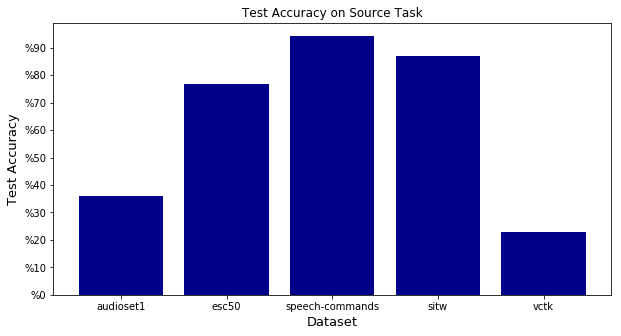

In [333]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

projects = ('audioset1-train-and-evaluate',
            'esc50-train-and-evaluate',
            'speech-commands-train-and-evaluate',
            'sitw-train-and-evaluate',
            'vctk-train-and-evaluate')


results = {}

for project in projects:
    best_val = 0.
    experiments = client.get(f"co-jl-transfer/{project}")
    for exp in experiments:
        tags = client.get_experiment_tags(exp)
        if 'candidate' in tags:
            metrics = client.get_experiment_metrics(exp)
            for metric in metrics:
                if metric['name'] == 'test_accuracy':
                    best_val = metric['valueMax']

    results[project.replace('-train-and-evaluate','')] = float(best_val)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(list(results.keys()), list(results.values()), color='darkblue')
plt.yticks(np.arange(10) / 10, [f'%{(v) * 10}' for v in range(10)])

ax.set_title("Test Accuracy on Source Task")
ax.set_xlabel("Dataset", fontsize=13)
ax.set_ylabel("Test Accuracy", fontsize=13)
plt.show()